In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_rel

from utils import *

%load_ext autoreload
%autoreload 2


## Load in

In [2]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]

df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

# filter for heart failure
df = df[df["condition_name"] == "Heart Failure"]

# drop nans
df.dropna(inplace=True)

# calculate readmission rate & drop the original columns
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df.drop(
    columns=["number_of_readmissions", "number_of_discharges", "condition_name"],
    inplace=True,
)

# right skewed dist -> log transform
log_transform = [
    "avg_payment_amount_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
]

for col in log_transform:
    df[col] = np.log10(df[col])

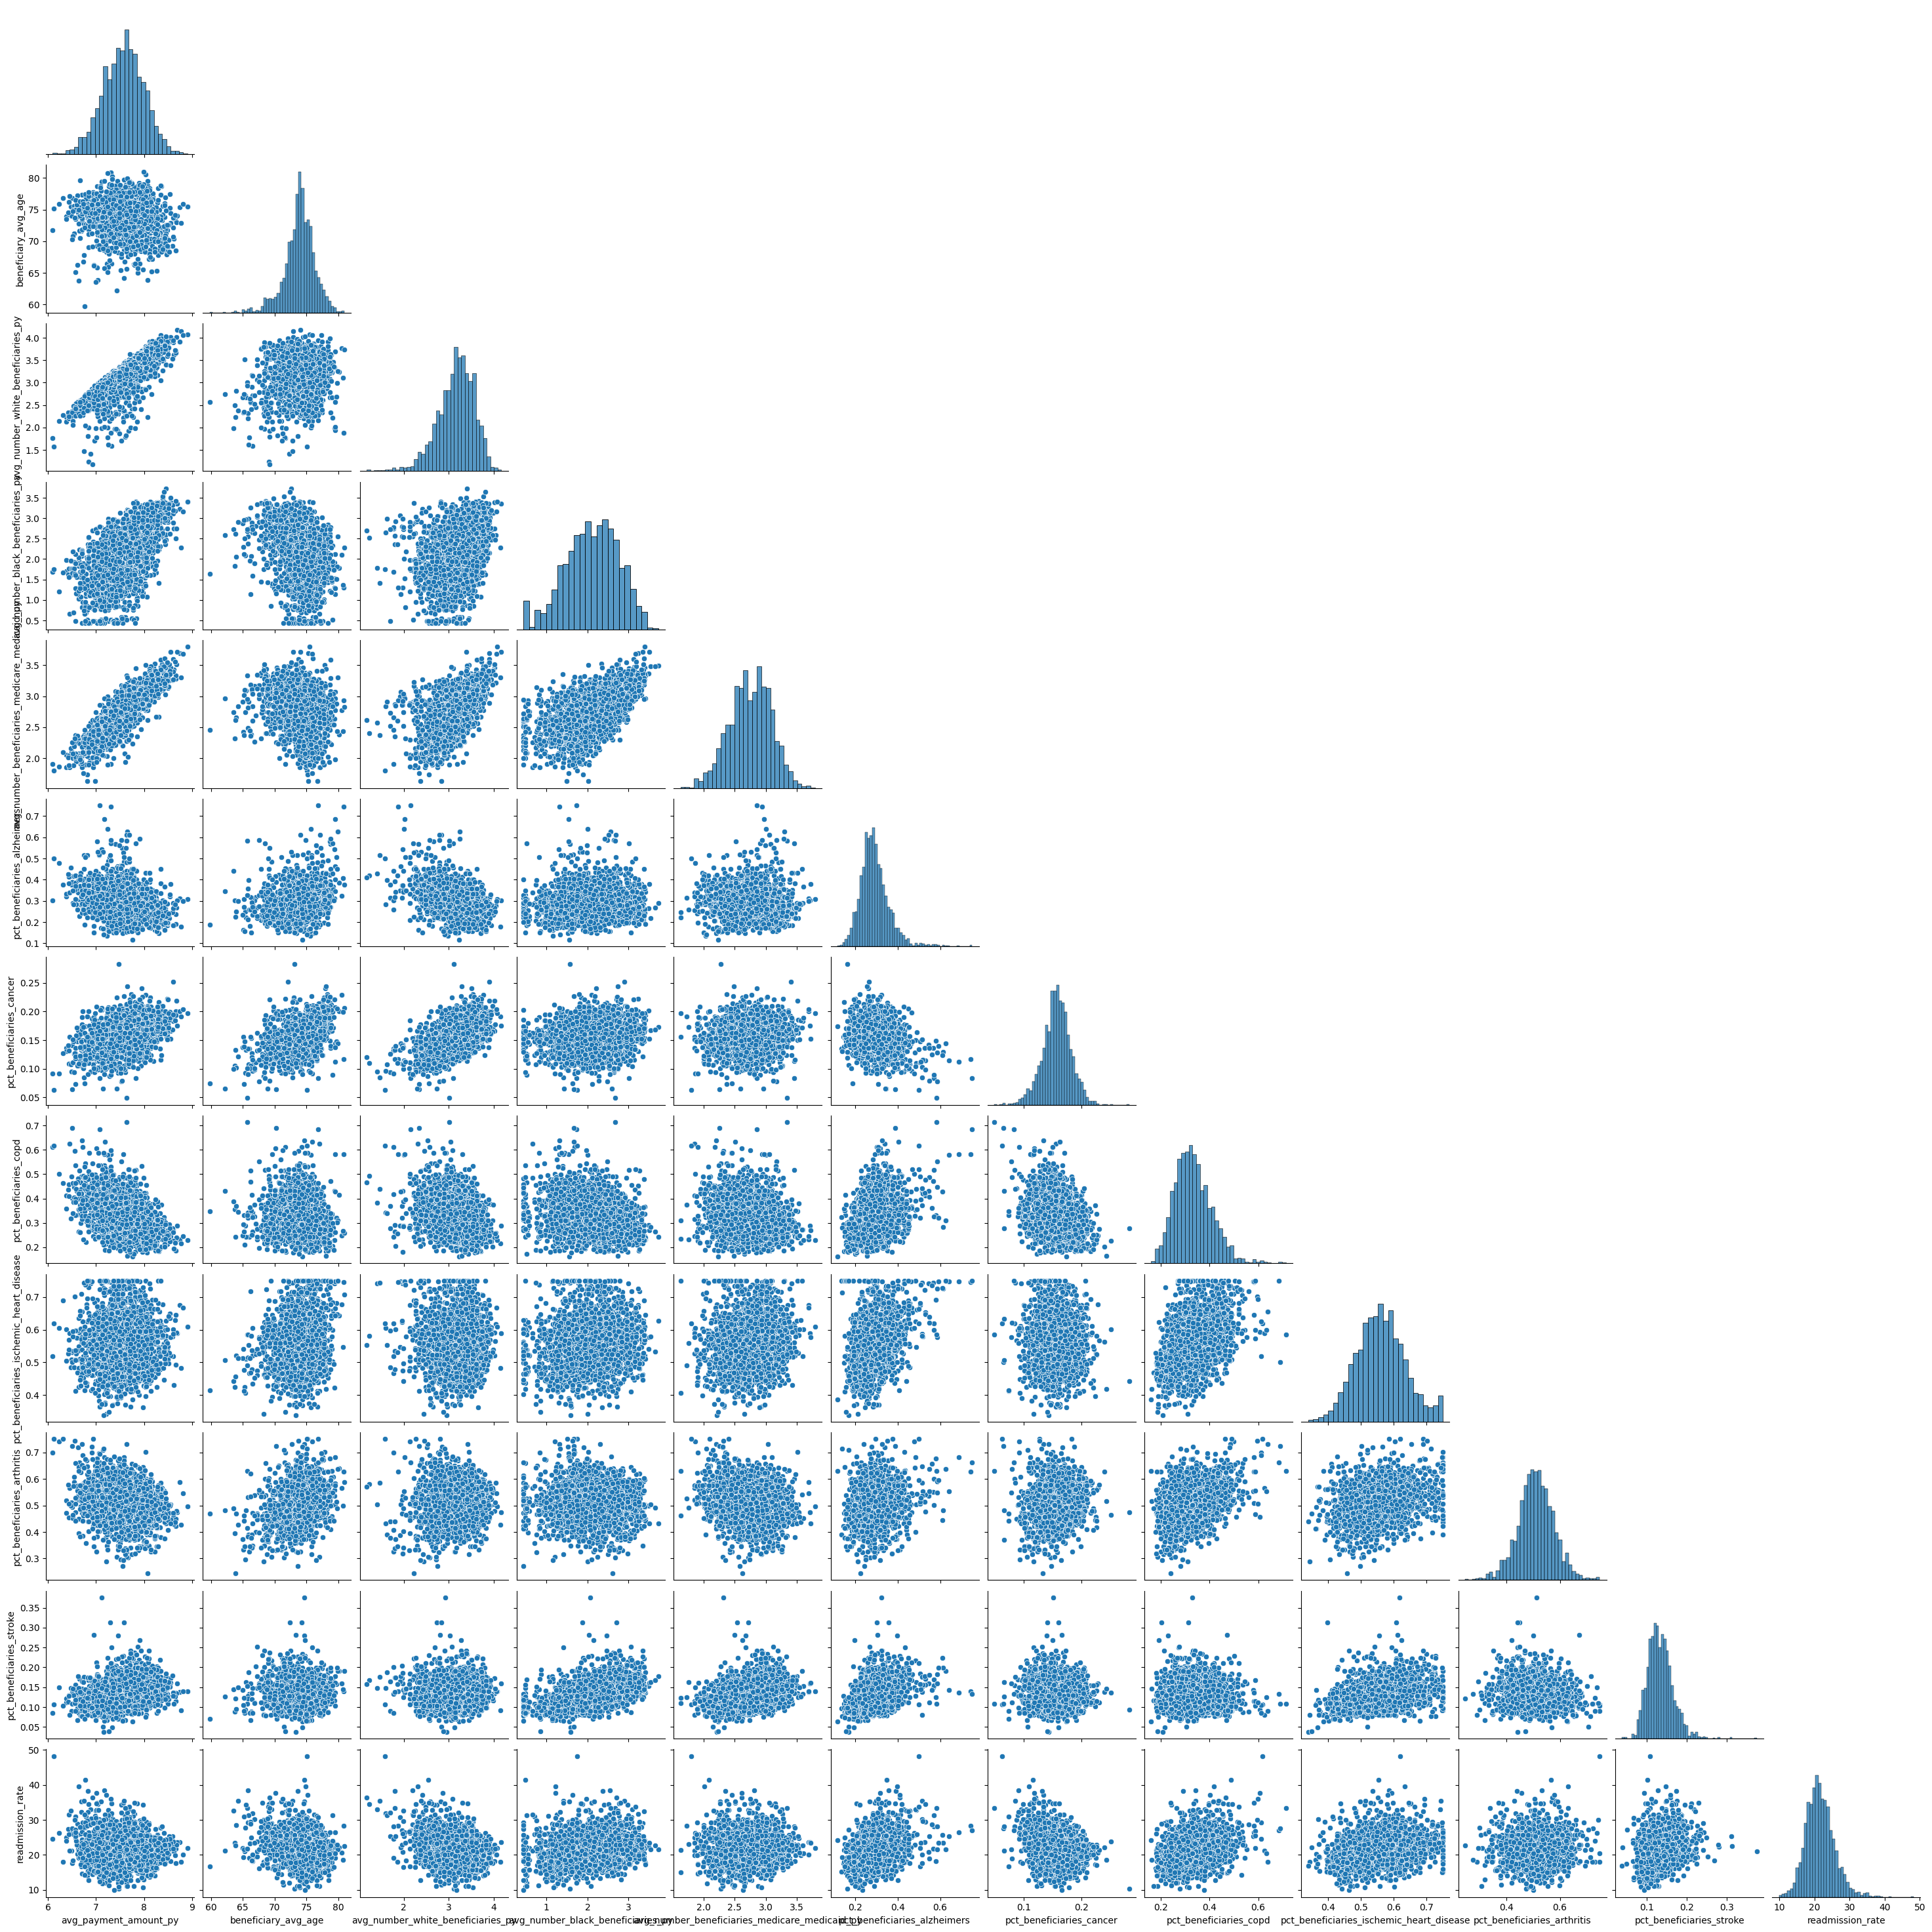

In [3]:
sns.pairplot(df, corner=True)

### Standardize and scale

In [4]:
X = df.drop(columns=["readmission_rate"])
X_standardized = process_features(
    X, numeric_cols=X.select_dtypes(include="float").columns.tolist()
)

## Fit

In [5]:
num_iterations = 1
features_A = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
]

features_B = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]

X_standardized.reset_index(drop=True, inplace=True)
y = df["readmission_rate"]
y.reset_index(drop=True, inplace=True)

In [23]:
num_iterations = 2000
results_list_A = []
results_list_B = []
for i in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        X_standardized,
        y,
        test_size=0.2,
    )
    X_train_A = sm.add_constant(X_train)
    X_test_A = sm.add_constant(X_test)

    X_train_B, X_test_B = X_train_A[features_B], X_test_A[features_B]
    X_train_B = sm.add_constant(X_train_B)
    X_test_B = sm.add_constant(X_test_B)

    # A- fit
    linear_model_A = sm.OLS(y_train, X_train_A)
    linear_model_A = linear_model_A.fit()

    # A- evaluate
    y_pred_A = linear_model_A.predict(X_test_A)
    mse_A = mean_squared_error(y_test, y_pred_A)
    r2_A = r2_score(y_test, y_pred_A)
    coefficients_A = linear_model_A.params[1:]  # Exclude the bias term

    results_A = {
        "iteration": i,
        "model": "A",
        "mse": mse_A,
        "rmse": np.sqrt(mse_A),
        "r2": r2_A,
        **coefficients_A.to_dict(),
    }
    results_list_A.append(results_A)

    # B- fit
    linear_model_B = sm.OLS(y_train, X_train_B)
    linear_model_B = linear_model_B.fit()

    # B- evaluate
    y_pred_B = linear_model_B.predict(X_test_B)
    mse_B = mean_squared_error(y_test, y_pred_B)
    r2_B = r2_score(y_test, y_pred_B)
    coefficients_B = linear_model_B.params[1:]  # Exclude the bias term
    results_B = {
        "iteration": i,
        "model": "B",
        "mse": mse_B,
        "rmse": np.sqrt(mse_B),
        "r2": r2_B,
        **coefficients_B.to_dict(),
    }
    results_list_B.append(results_B)

# Create DataFrames for Models A and B
results_df_A = pd.DataFrame(results_list_A)
results_df_B = pd.DataFrame(results_list_B)

# Concatenate DataFrames for Models A and B
results_df = pd.concat([results_df_A, results_df_B], ignore_index=True)

## Eval

Text(0.5, 1.0, 'R2')

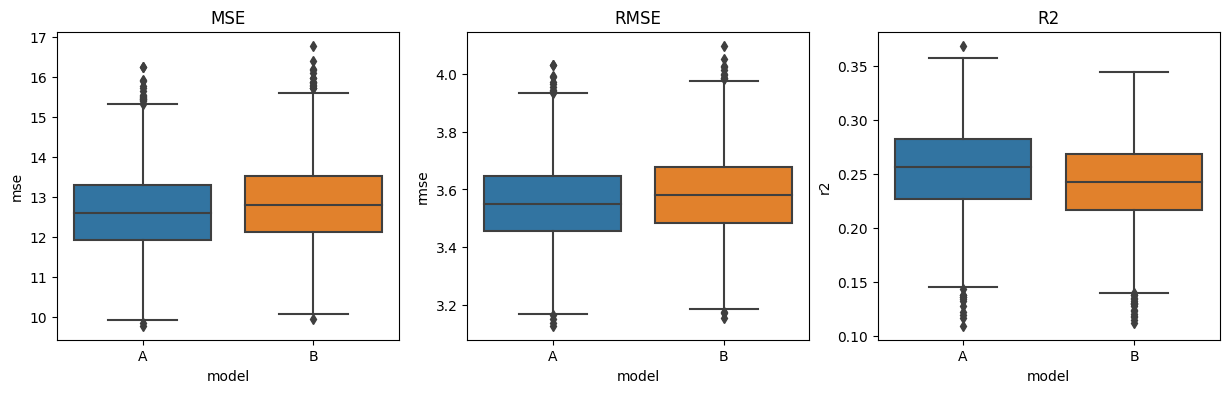

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0])
sns.boxplot(data=results_df, x="model", y="rmse", dodge=False, ax=ax[1])
sns.boxplot(data=results_df, x="model", y="r2", dodge=False, ax=ax[2])

ax[0].set_title("MSE")
ax[1].set_title("RMSE")
ax[2].set_title("R2")

<Axes: xlabel='model', ylabel='r2'>

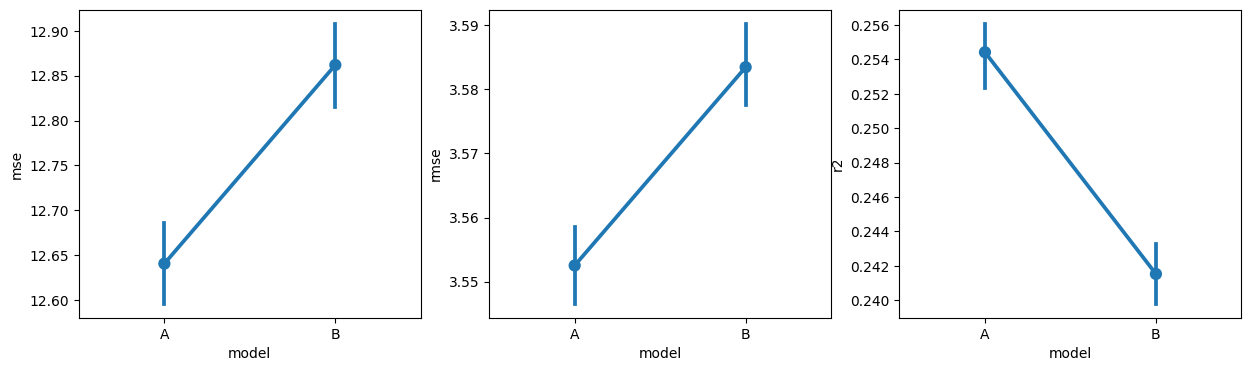

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.pointplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0])
sns.pointplot(data=results_df, x="model", y="rmse", dodge=False, ax=ax[1])
sns.pointplot(data=results_df, x="model", y="r2", dodge=False, ax=ax[2])

# ax[0].set(title=("MSE"), ylim=(12, 13.5))
# ax[1].set(title=("RMSE"), ylim=(3.4, 3.7))
# ax[2].set(title=("R2"), ylim=(0.220, 0.27))

<Axes: xlabel='model', ylabel='r2'>

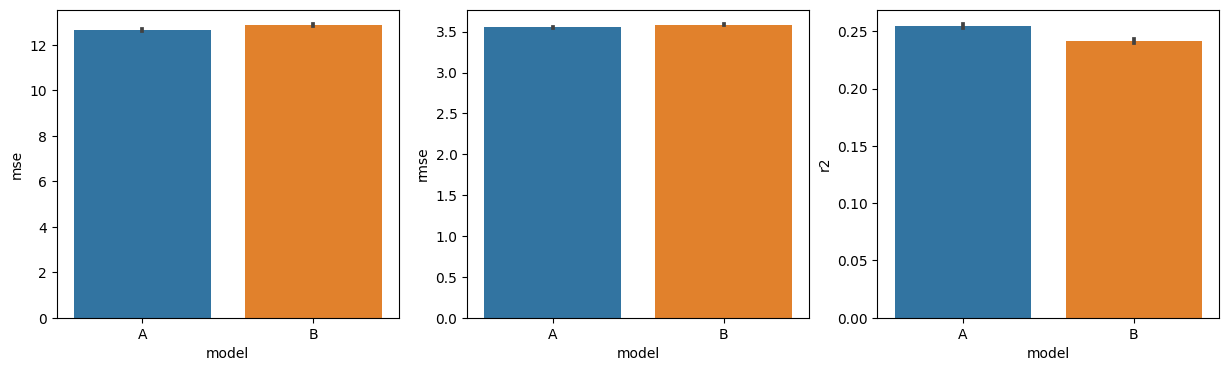

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0])
sns.barplot(data=results_df, x="model", y="rmse", dodge=False, ax=ax[1])
sns.barplot(data=results_df, x="model", y="r2", dodge=False, ax=ax[2])

# ax[0].set(title=("MSE"), ylim=(12, 13.5))
# ax[1].set(title=("RMSE"), ylim=(3.4, 3.7))
# ax[2].set(title=("R2"), ylim=(0.220, 0.27))

In [27]:
# Separate MSE scores for models A and B
mse_A = results_df[results_df["model"] == "A"]["mse"]
mse_B = results_df[results_df["model"] == "B"]["mse"]

# Perform a paired t-test
t_statistic, p_value = ttest_rel(mse_A, mse_B)

print("Paired t-test results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Interpret the p-value to determine if the models are significantly different
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The models are significantly different.")
else:
    print("There is no significant difference between the models.")

Paired t-test results:
t-statistic: -51.41737553864497
p-value: 0.0
The models are significantly different.


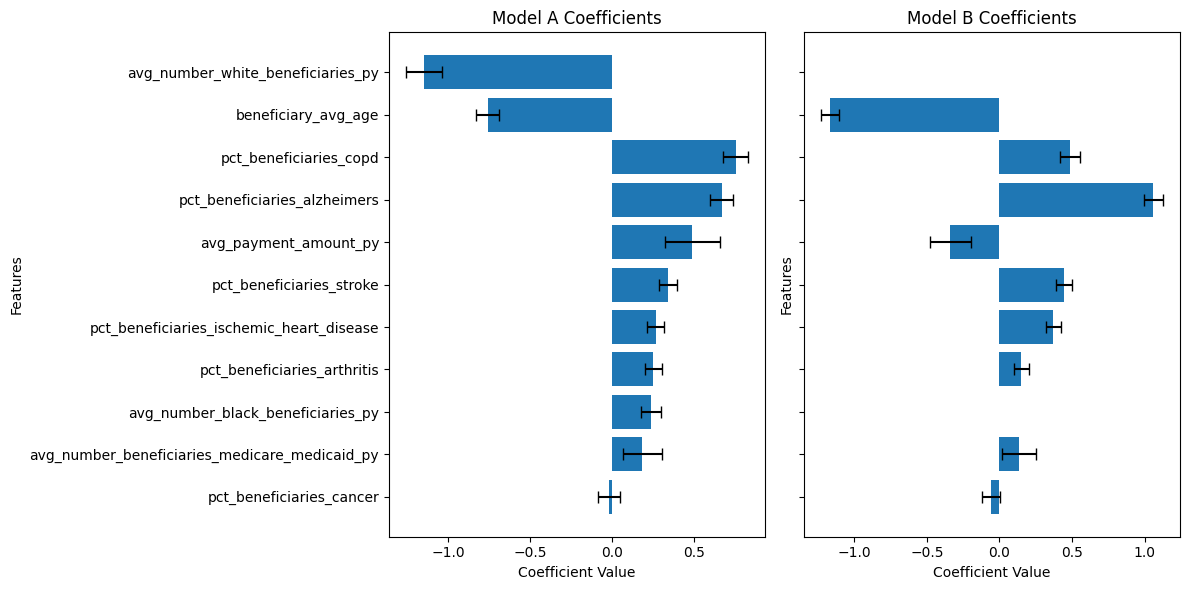

In [28]:
# Calculate mean coefficients and standard deviations for models A and B
coefficients_A_mean = results_df[results_df["model"] == "A"][features_A].mean()
coefficients_A_std = results_df[results_df["model"] == "A"][features_A].std()

coefficients_B_mean = results_df[results_df["model"] == "B"][features_A].mean()
coefficients_B_std = results_df[results_df["model"] == "B"][features_A].std()

# Sort coefficients for model A by absolute value in descending order
coefficients_A_sorted_idx = (
    np.abs(coefficients_A_mean).sort_values(ascending=True).index
)
coefficients_A_mean_sorted = coefficients_A_mean[coefficients_A_sorted_idx]
coefficients_A_std_sorted = coefficients_A_std[coefficients_A_sorted_idx]

# Sort coefficients for model B using the same sorting order as model A
coefficients_B_mean_sorted = coefficients_B_mean[coefficients_A_sorted_idx]
coefficients_B_std_sorted = coefficients_B_std[coefficients_A_sorted_idx]

# Create a fig
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot coefficients for model A with error bars
axs[0].barh(
    coefficients_A_mean_sorted.index,
    coefficients_A_mean_sorted.values,
    xerr=coefficients_A_std_sorted,
    capsize=4,
)
axs[0].set_title("Model A Coefficients")
axs[0].set_xlabel("Coefficient Value")
axs[0].set_ylabel("Features")

# Plot coefficients for model B with error bars
axs[1].barh(
    coefficients_B_mean_sorted.index,
    coefficients_B_mean_sorted.values,
    xerr=coefficients_B_std_sorted,
    capsize=4,
)
axs[1].set_title("Model B Coefficients")
axs[1].set_xlabel("Coefficient Value")
axs[1].set_ylabel("Features")

# Adjust layout and display the plot
plt.tight_layout()

In [29]:
results_df.to_csv("lm_results_df.csv", index=False)